In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Link to "Folder_Labelled" file is shared along with the solution. This folder is shared through g-drive.
# In "Folder_Labelled", separate folders are created for each class of flowers that contain all the respective images of that class.
base_dir = '/content/drive/MyDrive/IE643_Assignment2/Folder_Labelled'     #Please provide the link to "Folder_Labelled" folder here.
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


In [ ]:
#Only class-9 (class numbering starts from 0,1,2..) is selected. This roughly appears to be sunflower category.

mb_size = 4   #Mini-batch size

def get_indices(dataset, k):
    indices =  []
    sub_data = []
    for i in range(len(dataset.targets)):  #use train_labels if error with tragets 
        if dataset.targets[i] == k :  # or dataset.targets[i] == 4 or dataset.targets[i] == 6:
            indices.append(i)   #indices of data with labels 2, 4 or 6
            sub_data.append(dataset[i])
    return indices, sub_data

idx, sub_data = get_indices(dataset, 9)       #Class-9 is selected for training purpose.
print(len(idx))

from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)

trainLoader = torch.utils.data.DataLoader(dataset,batch_size=mb_size, 
                                          sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train))

80


In [ ]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [ ]:
imgs.shape  #shape of the tensor data obtained from the train loader

torch.Size([4, 3, 64, 64])

In [ ]:
#visualization of data on a grid
def imshow(imgs):
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

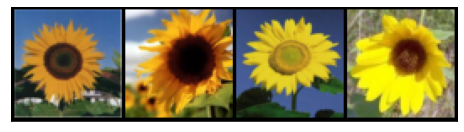

In [ ]:
imshow(imgs) #using imshow() to obtain the grid

![Generative Adversarial Network](https://www.kdnuggets.com/wp-content/uploads/generative-adversarial-network.png)

In [ ]:
# Generator Code
nc = 3  # Number of channels in the training images. For color images this is 3
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator

class DC_Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
#Discriminator Code
ndf = 64  # Size of feature maps in discriminator

class DC_Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_G = DC_Gen().to(device)
DC_D = DC_Dis().to(device)

#print(DC_G)
#print(DC_D)

In [ ]:
lr = 1e-3  #learning rate
#optimizers for both models
g_opt = opt.Adam(DC_G.parameters(), lr=lr)
d_opt = opt.Adam(DC_D.parameters(), lr=lr)

In [ ]:
epoch_list=[]
g_loss_list=[]
d_loss_list=[]
train_obj_list=[]
for epoch in range(300):
    G_loss_run = 0.0
    D_loss_run = 0.0
    
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.to(device)
        #X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, device=device)
        zero_labels = torch.zeros(mb_size, device=device)
        
        z = torch.randn(mb_size, nz, 1, 1, device=device)
        
        D_real = DC_D(X)
        D_fake = DC_D(DC_G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real.view(-1), one_labels)  #loss -(1/m)(log D(x))
        D_fake_loss = F.binary_cross_entropy(D_fake.view(-1), zero_labels)  #loss -(1/m)(log(1-D(G(z))))
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, nz, 1, 1, device=device)
        
        D_fake = DC_D(DC_G(z))
        G_loss = F.binary_cross_entropy(D_fake.view(-1), one_labels)  #loss -(1/m)(log (1-D(G(z))))
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    epoch_list.append(epoch)
    g_loss_list.append(G_loss_run/(i+1))
    d_loss_list.append(D_loss_run/(i+1))
    train_obj_list.append((G_loss_run/(i+1)) + (D_loss_run/(i+1)))
    
    # with torch.no_grad():
    #     samples = DC_G(z).detach().cpu()
    #     samples = samples.view(samples.size(0), 3, 64, 64)
    #     imshow(samples)
    

Epoch:0,   G_loss:12.908906433317396,    D_loss:1.1441537025764572
Epoch:1,   G_loss:12.526112609439426,    D_loss:0.36239084497517776
Epoch:2,   G_loss:11.424469232559204,    D_loss:0.19675525824358273
Epoch:3,   G_loss:10.04121200243632,    D_loss:0.22682460594741213
Epoch:4,   G_loss:8.69362990061442,    D_loss:0.1427314601217707
Epoch:5,   G_loss:8.416632387373182,    D_loss:0.20435386802354413
Epoch:6,   G_loss:9.161782344182333,    D_loss:0.08653109737012225
Epoch:7,   G_loss:9.38486835691664,    D_loss:0.0525326374400821
Epoch:8,   G_loss:12.599764770931667,    D_loss:0.051231470985739075
Epoch:9,   G_loss:13.545082834031847,    D_loss:0.22287634104981813
Epoch:10,   G_loss:19.25203455819024,    D_loss:0.2866245609773175
Epoch:11,   G_loss:13.713717831505669,    D_loss:0.09469963712722852
Epoch:12,   G_loss:23.588708930545383,    D_loss:0.15211913642572958
Epoch:13,   G_loss:23.227232509189182,    D_loss:0.02052249269386862
Epoch:14,   G_loss:13.649032831192017,    D_loss:0.1437

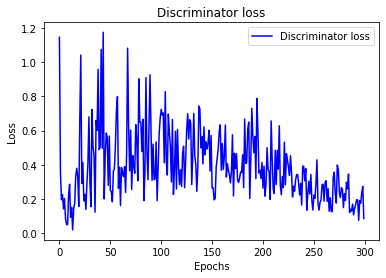

In [ ]:
plt.plot(epoch_list, d_loss_list, 'b', label='Discriminator loss')
plt.title('Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

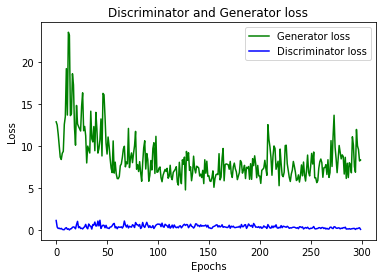

In [ ]:
plt.plot(epoch_list, g_loss_list, 'g', label='Generator loss')
plt.plot(epoch_list, d_loss_list, 'b', label='Discriminator loss')
plt.title('Discriminator and Generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

plt.plot(train_obj_list, d_loss_list, 'b', label='Discriminator loss')
plt.title('Discriminator and Generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

When the generator and descriminator are trained continuously for more number of epochs, usually the discriminator loss approaches zero and generator loss swings in range from 50-60.\
Increasing batch size while maintaining other hyper-parameters the same seems to prevent any kind of learning. The generator does not escape from the initial noise phase.\
Increasing or decreasing the learning rate casues the discriminator loss to quickly converge to zero within smaller training epochs.


But sometimes when the model is trained for more number of epochs, even though it creates wild fluctuations in generator loss (shoots upto 40-50 range but returns to 5-10 range), better minimas are obtained indicated by better qualitative images.These are some images after epoch 914,915 and 916. Better images could be because of overfitting and the network could be memorising some of the input data samples. 

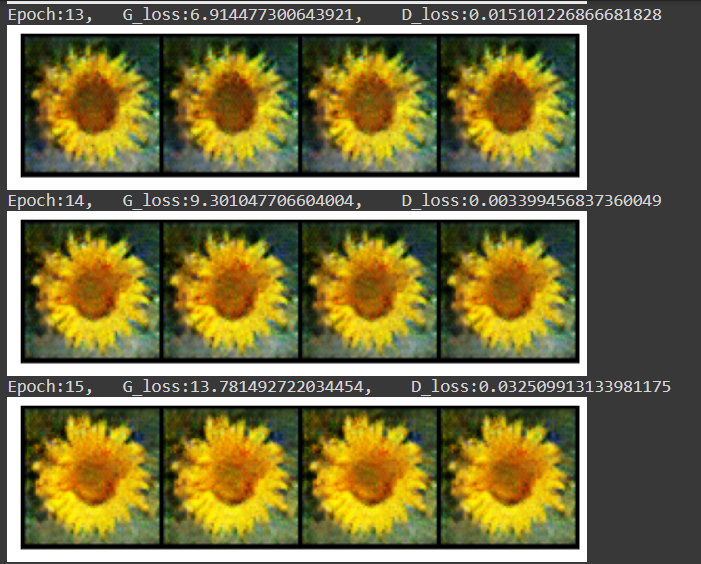

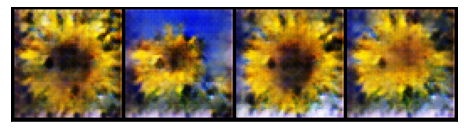

In [ ]:
    z = torch.randn(10, nz, 1, 1, device=device)
    with torch.no_grad():
        samples = DC_G(z).detach().cpu()
        samples = samples.view(samples.size(0), 3, 64, 64)
        imshow(samples)

In [ ]:
z=z = torch.randn(10, nz, 1, 1, device=device)
samples = DC_G(z).detach().cpu()
samples = samples.view(samples.size(0), 3, 64, 64)

list_0=[]
list_1=[]
list_2=[]
list_3=[]
list_4=[]
list_5=[]
list_6=[]
list_7=[]
list_8=[]
list_9=[]

for i in range(len(sub_data)):
  list_0.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[0]))
  list_1.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[1]))
  list_2.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[2]))
  list_3.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[3]))
  list_4.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[4]))
  list_5.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[5]))
  list_6.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[6]))
  list_7.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[7]))
  list_8.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[8]))
  list_9.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[9]))


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


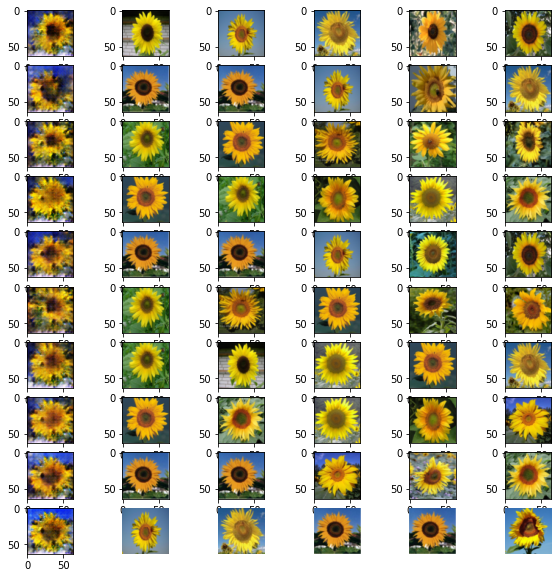

In [ ]:

fig, axs = plt.subplots(10, 6, figsize=(10,10))

for i in range(10):
  axs[i,0].imshow(np.transpose(vutils.make_grid(samples[i], normalize=True).cpu(),(1,2,0)))

for j in range(1,6):
    
    axs[0,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_0))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[1,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_1))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[2,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_2))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[3,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_3))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[4,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_4))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[5,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_5))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[6,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_6))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[7,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_7))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[8,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_8))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[9,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_9))[j-1]][0], normalize=True).cpu(),(1,2,0)))

    axs[i,j].axis('off')

Mean Squared error is the similarity metric that is used. It provides pixel wise comparision between images.